In [10]:
import wandb
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# ===== CONFIGURATION SECTION =====
# Just paste your values here and run!

# Main project configuration
PROJECT_NAME = "multiturn_island"  # Paste your project name here
ENTITY = None  # Set to your wandb entity if needed

# Run naming patterns - modify these to match your runs
PENALTY_RUN_PATTERN = "penalty"  # Runs with penalty (e.g., "acre-63", "acre-64")
NO_PENALTY_RUN_PATTERN = "no_penalty"  # Runs without penalty
SPLIT_MODEL_RUN_PATTERN = "shoggoth"  # Split model runs (set to None to exclude)

# Optional: Include split model results? Set to False to exclude
INCLUDE_SPLIT_MODEL = True

# Optional: Pull split model runs from a different project?
USE_SEPARATE_SPLIT_PROJECT = True  # Set to True to use different project for split model runs
SPLIT_PROJECT_NAME = "training-saes/multiturn_island"  # e.g., "other-user/split-model-project" or just "project-name"
SPLIT_ENTITY = None # Entity for split model project (if different from main entity)

# ===== END CONFIGURATION =====

# Initialize wandb API and load data
api = wandb.Api()
project_path = f"{ENTITY}/{PROJECT_NAME}" if ENTITY else PROJECT_NAME

print(f"Loading runs from project: {project_path}")
runs = api.runs(project_path)
print(f"Found {len(runs)} total runs")


Loading runs from project: multiturn_island
Found 20 total runs


In [11]:
# Filter runs from main project
filtered_runs = []
for run in runs:
    if not run.name:
        continue
    
    # Check if run matches penalty or no penalty patterns
    is_penalty = PENALTY_RUN_PATTERN in run.name
    is_no_penalty = NO_PENALTY_RUN_PATTERN in run.name
    
    # Only check for split model in main project if not using separate project
    is_split_model = (INCLUDE_SPLIT_MODEL and not USE_SEPARATE_SPLIT_PROJECT and 
                     SPLIT_MODEL_RUN_PATTERN and SPLIT_MODEL_RUN_PATTERN in run.name)
    
    # TEMPORARY: Filter shoggoth runs to only include numbers >= 17
    if is_split_model and SPLIT_MODEL_RUN_PATTERN in run.name:
        import re
        match = re.search(r'shoggoth[_-](\d+)', run.name)
        if match:
            run_number = int(match.group(1))
            if run_number < 17:
                is_split_model = False
    
    if is_penalty or is_no_penalty or is_split_model:
        filtered_runs.append(run)

print(f"Found {len(filtered_runs)} matching runs from main project")

# Optionally load split model runs from a separate project
if INCLUDE_SPLIT_MODEL and USE_SEPARATE_SPLIT_PROJECT and SPLIT_PROJECT_NAME:
    split_project_path = f"{SPLIT_ENTITY}/{SPLIT_PROJECT_NAME}" if SPLIT_ENTITY else SPLIT_PROJECT_NAME
    print(f"Loading split model runs from: {split_project_path}")
    
    try:
        split_runs = api.runs(split_project_path)
        split_filtered_runs = []
        
        for run in split_runs:
            if run.name and SPLIT_MODEL_RUN_PATTERN and SPLIT_MODEL_RUN_PATTERN in run.name:
                # TEMPORARY: Filter shoggoth runs to only include numbers >= 17
                import re
                match = re.search(r'shoggoth[_-](\d+)', run.name)
                if match:
                    run_number = int(match.group(1))
                    if run_number >= 17:
                        split_filtered_runs.append(run)
                else:
                    # Include runs without numbers (just in case)
                    split_filtered_runs.append(run)
        
        filtered_runs.extend(split_filtered_runs)
        print(f"Found {len(split_filtered_runs)} split model runs from separate project")
    except Exception as e:
        print(f"Error loading split model project: {e}")

print(f"Total matching runs: {len(filtered_runs)}")

# Load data for filtered runs
run_data = []
for run in filtered_runs:
    history = run.history()
    if len(history) > 0:  # Only include runs with data
        run_data.append({
            'name': run.name,
            'config': run.config,
            'history': history,
            'state': run.state
        })

print(f"Loaded data for {len(run_data)} runs with metrics")


Found 20 matching runs from main project
Loading split model runs from: training-saes/multiturn_island
Found 10 split model runs from separate project
Total matching runs: 30
Loaded data for 30 runs with metrics


Plotting 30 runs
Categories: {'Penalty': 10, 'No Penalty': 10, 'Split Model': 10}


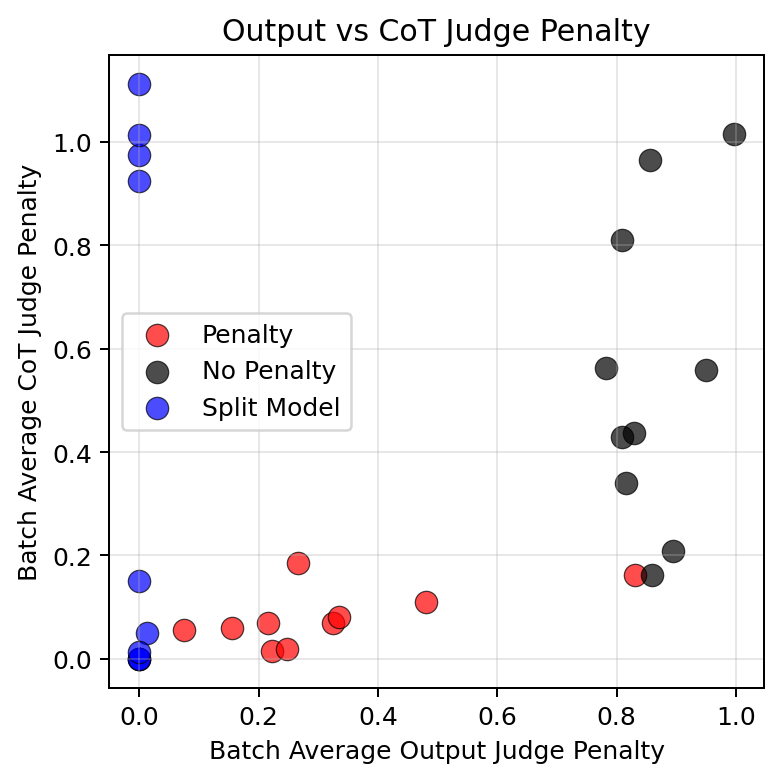

penalty-18 (Penalty): output=0.07, thinking=0.06
no_penalty-1 (No Penalty): output=0.81, thinking=0.43
penalty-20 (Penalty): output=0.33, thinking=0.07
no_penalty-2 (No Penalty): output=0.78, thinking=0.56
penalty-21 (Penalty): output=0.83, thinking=0.16
no_penalty-3 (No Penalty): output=1.00, thinking=1.02
penalty-22 (Penalty): output=0.22, thinking=0.07
no_penalty-4 (No Penalty): output=0.89, thinking=0.21
no_penalty-5 (No Penalty): output=0.95, thinking=0.56
no_penalty-6 (No Penalty): output=0.86, thinking=0.97
penalty-24 (Penalty): output=0.16, thinking=0.06
no_penalty-7 (No Penalty): output=0.82, thinking=0.34
penalty-25 (Penalty): output=0.22, thinking=0.02
no_penalty-8 (No Penalty): output=0.81, thinking=0.81
no_penalty-9 (No Penalty): output=0.83, thinking=0.44
penalty-27 (Penalty): output=0.33, thinking=0.08
no_penalty-10 (No Penalty): output=0.86, thinking=0.16
penalty-28 (Penalty): output=0.27, thinking=0.18
penalty-29 (Penalty): output=0.25, thinking=0.02
penalty-30 (Penalt

In [13]:
# Generate scatterplot
scatter_data = []

for run_info in run_data:
    history = run_info['history']
    name = run_info['name']
    config = run_info['config']
    
    # Check if we have the required columns
    if 'word_count_output' in history.columns and 'word_count_cot' in history.columns:
        # Use last 10 steps for averaging (excluding the very last step)
        num_steps = min(10, len(history) - 1)
        if num_steps > 0:
            final_steps = history.iloc[-num_steps-1:-1] if len(history) > num_steps else history.iloc[:-1]
            
            if len(final_steps) > 0:
                avg_output_words = final_steps['word_count_output'].mean()
                avg_thinking_words = final_steps['word_count_cot'].mean()
                
                # Categorize runs based on patterns
                if INCLUDE_SPLIT_MODEL and SPLIT_MODEL_RUN_PATTERN and SPLIT_MODEL_RUN_PATTERN in name:
                    category = 'Split Model'
                    color = 'blue'
                elif NO_PENALTY_RUN_PATTERN in name:
                    category = 'No Penalty'
                    color = 'black'
                elif PENALTY_RUN_PATTERN in name:
                    category = 'Penalty'
                    color = 'red'
                else:
                    category = 'Other'
                    color = 'gray'
                
                scatter_data.append({
                    'name': name,
                    'output_words': avg_output_words,
                    'thinking_words': avg_thinking_words,
                    'category': category,
                    'color': color
                })

# Create scatter plot
scatter_df = pd.DataFrame(scatter_data)
print(f"Plotting {len(scatter_df)} runs")
if len(scatter_df) > 0:
    print(f"Categories: {scatter_df['category'].value_counts().to_dict()}")

# Configure figure size and DPI like the original notebook
IMG_SIZE_REDUCE = 1.8  # Factor to reduce image size and increase dpi
orig_figsize = (8, 8)
reduced_figsize = (orig_figsize[0] / IMG_SIZE_REDUCE, orig_figsize[1] / IMG_SIZE_REDUCE)
dpi = 100 * IMG_SIZE_REDUCE

plt.figure(figsize=reduced_figsize, dpi=dpi)
for category in scatter_df['category'].unique():
    category_data = scatter_df[scatter_df['category'] == category]
    plt.scatter(
        category_data['output_words'], 
        category_data['thinking_words'],
        c=category_data['color'].iloc[0],
        alpha=0.7,
        s=80,
        label=category,
        edgecolors='black',
        linewidth=0.5
    )

plt.xlabel('Batch Average Output Judge Penalty')
plt.ylabel('Batch Average CoT Judge Penalty')
plt.title('Output vs CoT Judge Penalty')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Print summary
for _, row in scatter_df.iterrows():
    print(f"{row['name']} ({row['category']}): output={row['output_words']:.2f}, thinking={row['thinking_words']:.2f}")


In [ ]:
# Generate scatterplot with step 65 for split model runs
scatter_data = []

for run_info in run_data:
    history = run_info['history']
    name = run_info['name']
    config = run_info['config']
    
    # Check if we have the required columns
    if 'total_output_penalized_words' in history.columns and 'total_thinking_penalized_words' in history.columns:
        # Determine if this is a split model run
        is_split_run = INCLUDE_SPLIT_MODEL and SPLIT_MODEL_RUN_PATTERN and SPLIT_MODEL_RUN_PATTERN in name
        
        if is_split_run:
            # For split model runs: get results at step 65
            if len(history) >= 66:  # Need at least 66 rows to have step 65 (0-indexed)
                step_65_data = history.iloc[65:66]  # Get just step 65
                avg_output_words = step_65_data['total_output_penalized_words'].iloc[0]
                avg_thinking_words = step_65_data['total_thinking_penalized_words'].iloc[0]
            else:
                # Skip this run if it doesn't have step 65
                print(f"Skipping {name} - only has {len(history)} steps, need at least 66 for step 65")
                continue
        else:
            # For penalty/no-penalty runs: use last 10 steps for averaging (excluding the very last step)
            num_steps = min(10, len(history) - 1)
            if num_steps > 0:
                final_steps = history.iloc[-num_steps-1:-1] if len(history) > num_steps else history.iloc[:-1]
                
                if len(final_steps) > 0:
                    avg_output_words = final_steps['total_output_penalized_words'].mean()
                    avg_thinking_words = final_steps['total_thinking_penalized_words'].mean()
                else:
                    continue
            else:
                continue
        
        # Categorize runs based on patterns
        if INCLUDE_SPLIT_MODEL and SPLIT_MODEL_RUN_PATTERN and SPLIT_MODEL_RUN_PATTERN in name:
            category = 'Split Model'
            color = 'blue'
        elif NO_PENALTY_RUN_PATTERN in name:
            category = 'No Penalty'
            color = 'black'
        elif PENALTY_RUN_PATTERN in name:
            category = 'Penalty'
            color = 'red'
        else:
            category = 'Other'
            color = 'gray'
        
        scatter_data.append({
            'name': name,
            'output_words': avg_output_words,
            'thinking_words': avg_thinking_words,
            'category': category,
            'color': color
        })

# Create scatter plot
scatter_df = pd.DataFrame(scatter_data)
print(f"Plotting {len(scatter_df)} runs")
if len(scatter_df) > 0:
    print(f"Categories: {scatter_df['category'].value_counts().to_dict()}")

# Configure figure size and DPI like the original notebook
IMG_SIZE_REDUCE = 2  # Factor to reduce image size and increase dpi
orig_figsize = (8, 8)
reduced_figsize = (orig_figsize[0] / IMG_SIZE_REDUCE, orig_figsize[1] / IMG_SIZE_REDUCE)
dpi = 100 * IMG_SIZE_REDUCE

plt.figure(figsize=reduced_figsize, dpi=dpi)
for category in scatter_df['category'].unique():
    category_data = scatter_df[scatter_df['category'] == category]
    plt.scatter(
        category_data['output_words'], 
        category_data['thinking_words'],
        c=category_data['color'].iloc[0],
        alpha=0.7,
        s=80,
        label=category,
        edgecolors='black',
        linewidth=0.5
    )

plt.xlabel('Average Penalized Words in Output (per batch)')
plt.ylabel('Average Penalized Words in CoT (per batch)')
plt.title('Output vs CoT Penalized Words')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Print summary
for _, row in scatter_df.iterrows():
    print(f"{row['name']} ({row['category']}): output={row['output_words']:.2f}, thinking={row['thinking_words']:.2f}")
